In [1]:
import os
import io
import numpy as np
import requests

import torch
from torchvision import transforms
from PIL import Image
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt

from models.stargan import Generator
import image_utils

%matplotlib inline

In [2]:
G_path = "./generators/stargan_sleeves.pth"
G = Generator(c_dim=4)
G.load_state_dict(torch.load(G_path, map_location='cpu'))

sleeves = {
    "sleeveless": [0, 0, 0, 1],
    "short": [0, 0, 1, 0],
    "3/4": [1, 0, 0, 0],
    "long": [0, 1, 0, 0]}

def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

In [18]:
def generate_sleeves(img, sleeve_length):
    transform = transforms.Compose([
                transforms.Resize(128, interpolation=Image.ANTIALIAS),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    img_tensor = transform(img).unsqueeze(0)
    
    img_label = sleeves[sleeve_length]
    label_tensor = torch.FloatTensor(img_label).unsqueeze(0)
    
    fake_img = G(img_tensor, label_tensor)
    ndarry = denorm(fake_img.squeeze(0)).data.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    return Image.fromarray(ndarry)

In [46]:
data_path='../../data/fashion/dresses/'
features_path='../../data/features114/dresses/'
filenames = [file.split('.')[0] for file in os.listdir(data_path)]
features = np.array([image_utils.load_feature_vector(os.path.join(features_path, file + '.npy')) 
                            for file in filenames])

def find_similar_images(img, num_imgs=5, img_size=256):
    
    img = img.resize([img_size, img_size])
    feature64 = image_utils.get_image_feature_by_image(img, feature_size=64)
    feature50 = image_utils.get_image_feature_by_image(img, feature_size=50)
    feature = np.frombuffer(feature64 + feature50, dtype=np.uint8)
    
    dist = pairwise_distances(feature.reshape(1, -1), features)
    best_idx = dist.squeeze(0).argsort()[:num_imgs]
    
    fig, axarr = plt.subplots(ncols=num_imgs+1, nrows=1, figsize=(12, 12))

    axarr[0].imshow(img)
    axarr[0].axis('off')

    for i, idx in enumerate(best_idx):
        ax = axarr[i+1]
        img_path = filenames[idx]
        img = Image.open(os.path.join(data_path, img_path + '.jpg'))
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

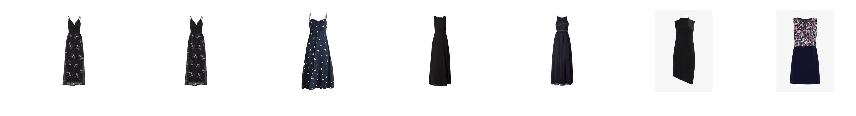

In [47]:
img_path = "./test_images/0affc348db5714e6515de3ea840a32eb.jpg"
img = Image.open(img_path)
find_similar_images(img, 6)

sleeveless


/Users/sonynka/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


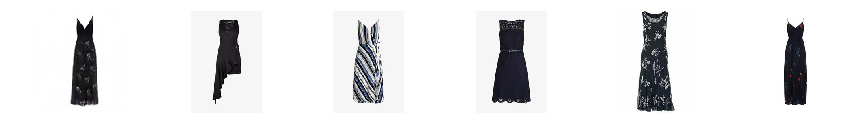

short


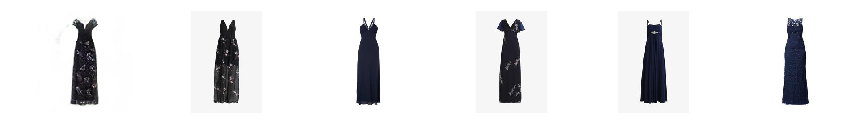

3/4


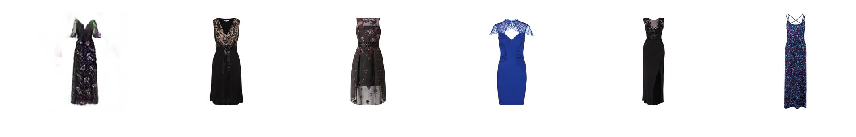

long


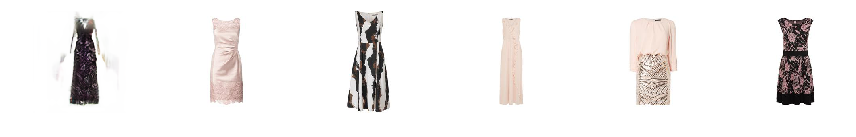

In [48]:
for sleeve_length in sleeves.keys():
    fake_img = generate_sleeves(img, sleeve_length)
    find_similar_images(fake_img)

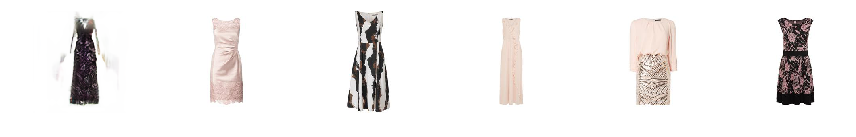

In [38]:
find_similar_images(fake_img)

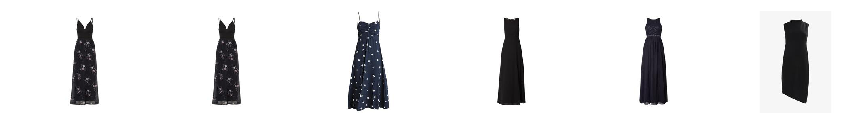

In [39]:
find_similar_images(img)

In [7]:
data_path = '../../data/fashion/dresses/'
feature114_path = '../../data/features114/dresses/'

filenames = [file.split('.')[0] for file in os.listdir(data_path)]
features114 = np.array([image_utils.load_feature_vector(os.path.join(feature114_path, file + '.npy')) 
                       for file in filenames])

In [ ]:
best_idx = dist.squeeze(0).argsort()[:5]
best_idx

In [ ]:
fig, axarr = plt.subplots(ncols=len(best_idx)+1, nrows=1, figsize=(12, 12))

orig_img = Image.fromarray(fake_img)
axarr[0].imshow(orig_img)
axarr[0].axis('off')

for i, idx in enumerate(best_idx):
    ax = axarr[i+1]
    img_path = filenames[idx]
    img = Image.open(os.path.join(data_path, img_path + '.jpg'))
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()